Dataset from this Kaggle competition:
https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset

Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from IPython.display import Image
from sklearn.tree import export_graphviz

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.feature_selection import SelectKBest, chi2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Load and Inspect data

In [2]:
data = pd.read_csv("data.csv")

data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Some columns are missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
# Various statistics about numerical columns of data
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Data Cleaning

Visualizing columns with missing data before data replacement

<AxesSubplot:xlabel='Gender', ylabel='count'>

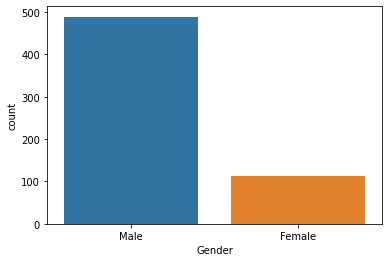

In [5]:
sns.countplot(x = "Gender", data = data)

<AxesSubplot:xlabel='Dependents', ylabel='count'>

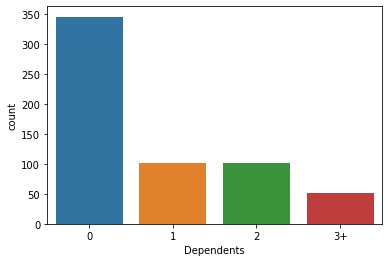

In [6]:
sns.countplot(x = "Dependents", data = data)

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

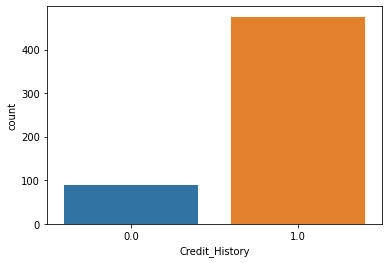

In [7]:
sns.countplot(x = "Credit_History", data = data)

<AxesSubplot:xlabel='Self_Employed', ylabel='count'>

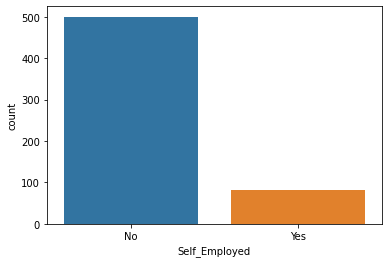

In [8]:
sns.countplot(x = "Self_Employed", data = data)

<AxesSubplot:xlabel='LoanAmount'>

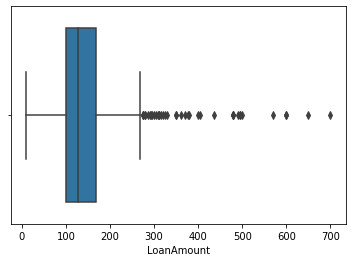

In [9]:
# Boxplot instead of countplot to better assess the data
sns.boxplot(x = "LoanAmount", data = data)

In [10]:
# Replace missing values with mode
data["Gender"] = data["Gender"].fillna(data["Gender"].mode()[0])
data["Dependents"] = data["Dependents"].fillna(data["Dependents"].mode()[0])
data["Credit_History"] = data["Credit_History"].fillna(data["Credit_History"].mode()[0])
data["Self_Employed"] = data["Self_Employed"].fillna(data["Self_Employed"].mode()[0])
data["Loan_Amount_Term"] = data["Loan_Amount_Term"].fillna(data["Loan_Amount_Term"].mode()[0])
data["Credit_History"] = data["Credit_History"].fillna(data["Credit_History"].mode()[0])

# Use median instead of mode for LoanAmount to remove/reduce impact of outliers
data["LoanAmount"] = data["LoanAmount"].fillna(data["LoanAmount"].median())

In [11]:
# Re-inspect; we see all columns have 367 rows of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


EDA (exploratory data analysis)

In [12]:
# Drop the 'Loan_ID' column since it's not useful
data = data.drop(["Loan_ID"], axis = 1)

Change non-numerical data to numerical values

In [13]:
le = LabelEncoder()

# Programmatically encode each column
for col in data:
    if data[col].dtypes == 'object':
        data[col] = le.fit_transform(data[col])

In [14]:
# Example Row 0:
# Gender 1 = Male, Married 1 = Yes, Dependents 0 = None/0, Education 0 = Graduate,
# Self_Employed 0 = False, Property_Area 2 = Urban, Credit_History 1 = Yes/True,
# Loan_Status 1 = Approved
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,128.0,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


Feature correlations

AxesSubplot(0.125,0.125;0.62x0.755)


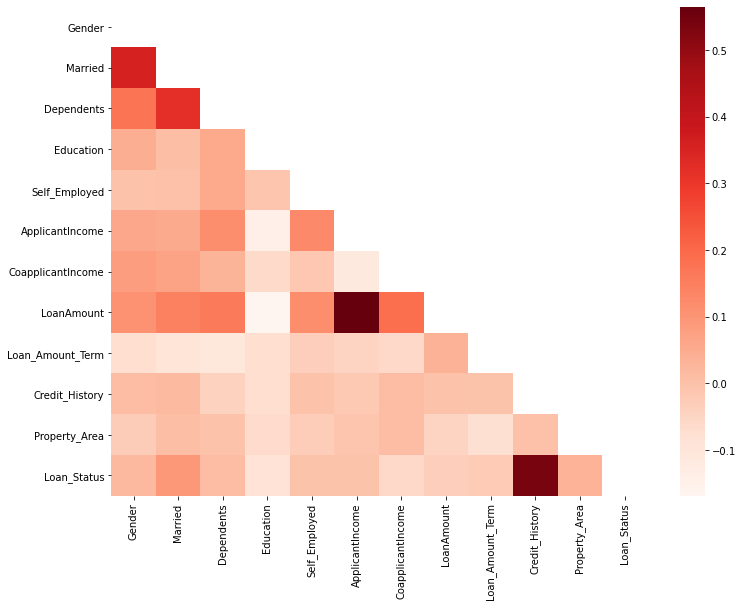

In [15]:
# Darker color mean stronger correlation between 2 columns
correlations = data.corr()
f, ax = plt.subplots(figsize = (12, 9))

# 2 lines prevent the 'mirrored' half of the same data from showing up
mask = np.zeros_like(correlations, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

heatmap = sns.heatmap(correlations, cmap = 'Reds', mask = mask)
print(heatmap)

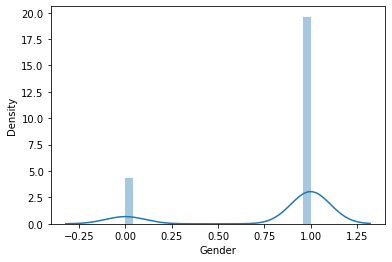

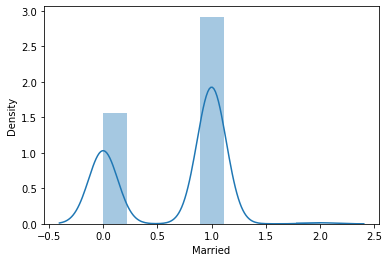

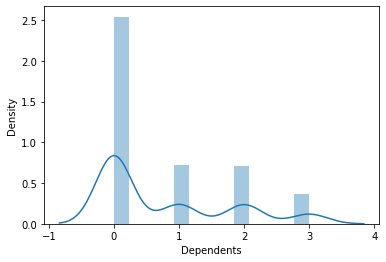

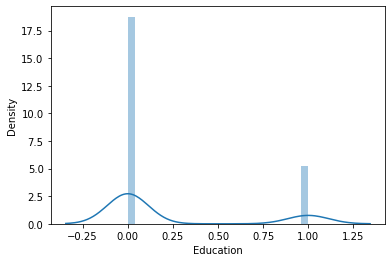

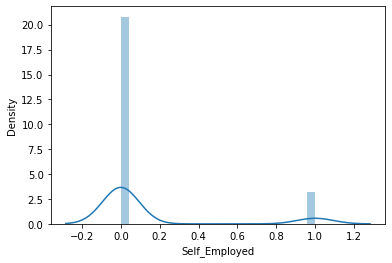

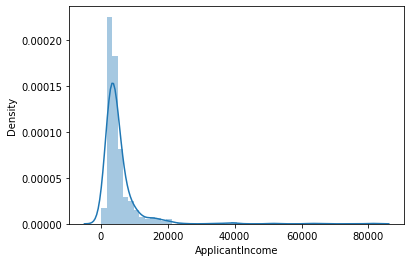

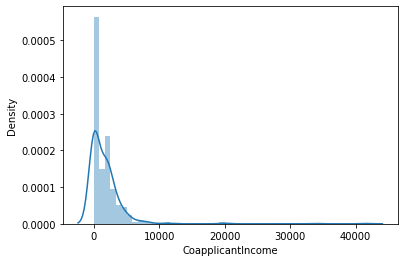

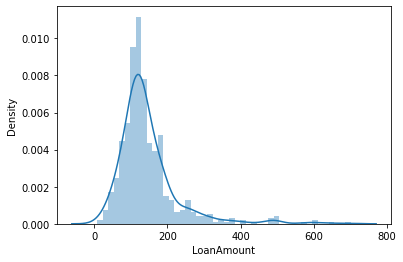

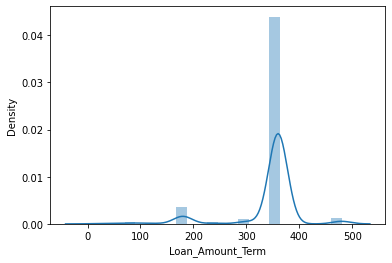

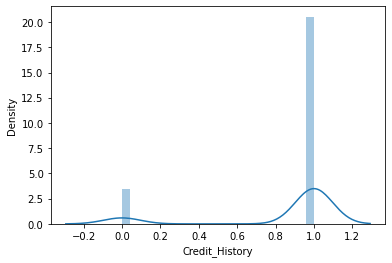

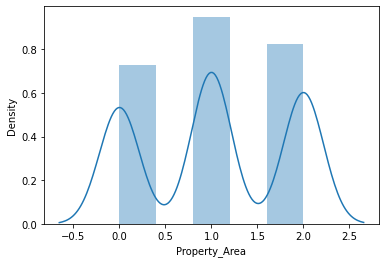

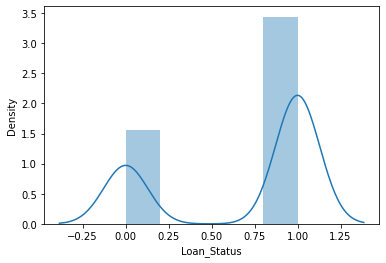

In [16]:
# Create a reusable function to display plots
def plotDistPlot(col):
    sns.distplot(col)
    plt.show()
    
    
for col in data:
    plotDistPlot(data[col])

Look into a few columns; if impacts loan approvals

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

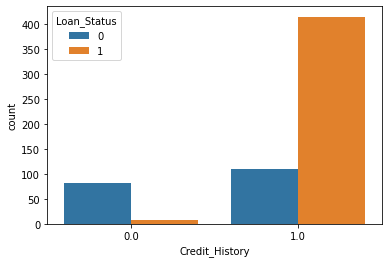

In [17]:
# Loan_Status 1 = Loan approved; Credit_History 1 = Yes/True
sns.countplot(x="Credit_History", hue="Loan_Status", data=data)

<AxesSubplot:xlabel='Gender', ylabel='count'>

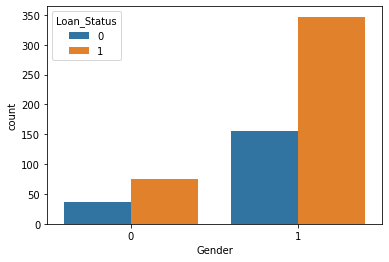

In [18]:
# Loan_Status 1 = Loan approved; Gender 1 = Male
sns.countplot(x="Gender", hue="Loan_Status", data=data)

<AxesSubplot:xlabel='Dependents', ylabel='count'>

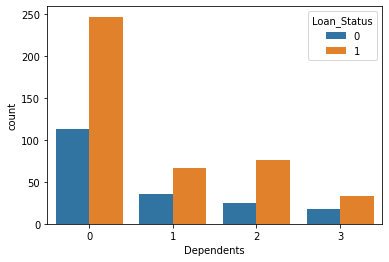

In [19]:
# Loan_Status 1 = Loan approved; Dependents 0 = No Dependents (1 = 1, 2 = 2, 3 = 3+ dependents)
sns.countplot(x="Dependents", hue="Loan_Status", data=data)

Data modeling prep

In [20]:
# Prep before train_test_split
X = data.drop(columns=['Loan_Status'], axis=1)
y = data['Loan_Status']

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
# Function to print out model assessment results
def print_metrics(y_test, y_pred):
    print('Accuracy Score is:', accuracy_score(y_test, y_pred) * 100)
    print()
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print('Classification report:')
    print(classification_report(y_test, y_pred))

Initial round of modeling and assessment results

Default settings, nothing extra

In [23]:
# Our group decided to use the RandomForest Classifier
# For baseline, we compared it to Logistic Regression

classifiers = [LogisticRegression(random_state = 42, solver = 'liblinear'),
               RandomForestClassifier(random_state = 42, n_estimators = 100)]

for clfs in classifiers:
    clfs.fit(x_train, y_train)
    print('Model name:', clfs.__class__.__name__)
    predict = clfs.predict(x_test)
    print_metrics(y_test, predict)
    print("ROC-AUC:", roc_auc_score(y_test, clfs.predict_proba(x_test)[:,1]))
    print("=" * 60)

Model name: LogisticRegression
Accuracy Score is: 77.27272727272727

Confusion matrix:
[[21 33]
 [ 2 98]]

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.39      0.55        54
           1       0.75      0.98      0.85       100

    accuracy                           0.77       154
   macro avg       0.83      0.68      0.70       154
weighted avg       0.81      0.77      0.74       154

ROC-AUC: 0.774074074074074
Model name: RandomForestClassifier
Accuracy Score is: 77.27272727272727

Confusion matrix:
[[25 29]
 [ 6 94]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.46      0.59        54
           1       0.76      0.94      0.84       100

    accuracy                           0.77       154
   macro avg       0.79      0.70      0.72       154
weighted avg       0.78      0.77      0.75       154

ROC-AUC: 0.7857407407407407


2nd round of modeling and assessment results

Using GridSearch and cross validation; optimizing for F1 score

In [24]:
log_reg = LogisticRegression(n_jobs = -1)

log_reg_grid = {
    'random_state' : [42],
    'solver' : ['liblinear'],
    'max_iter' : [0, 1000, 5000, 10000],
    'multi_class' : ['auto']
}

log_grid = GridSearchCV(estimator = log_reg, param_grid = log_reg_grid, scoring = 'f1', cv = 10)
log_grid.fit(x_train, y_train)

print('Model name:', log_reg.__class__.__name__)
print()
print('Best parameters:', log_grid.best_params_)
print()
y_pred = log_grid.predict(x_test)
print('10 Fold Cross Validation Accuracy Score:', log_grid.score(x_test, y_test) * 100)
print()
print('Optimized F1-Score:', f1_score(y_test, y_pred) * 100)
print()
print('Classification report:')
print(classification_report(y_test, y_pred))
print()
print("ROC-AUC:", roc_auc_score(y_test, log_grid.predict_proba(x_test)[:,1]))

Model name: LogisticRegression

Best parameters: {'max_iter': 1000, 'multi_class': 'auto', 'random_state': 42, 'solver': 'liblinear'}

10 Fold Cross Validation Accuracy Score: 84.84848484848484

Optimized F1-Score: 84.84848484848484

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.39      0.55        54
           1       0.75      0.98      0.85       100

    accuracy                           0.77       154
   macro avg       0.83      0.68      0.70       154
weighted avg       0.81      0.77      0.74       154


ROC-AUC: 0.774074074074074


In [25]:
rf_class = RandomForestClassifier(n_jobs = -1)

rfc_grid = {
    'n_estimators' : [50, 100, 150],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [0, 5, 10, 20],
    'min_samples_split' : [6, 8, 10],
    'random_state' : [42]
}

rfc_grid = GridSearchCV(estimator = rf_class, param_grid = rfc_grid, scoring = 'f1', cv = 10)
rfc_grid.fit(x_train, y_train)

print('Model name:', rf_class.__class__.__name__)
print()
print('Best parameters:', rfc_grid.best_params_)
print()
y_pred = rfc_grid.predict(x_test)
print('10 Fold Cross Validation Accuracy Score:', rfc_grid.score(x_test, y_test) * 100)
print()
print('Optimized F1-Score:', f1_score(y_test, y_pred) * 100)
print()
print('Classification report:')
print(classification_report(y_test, y_pred))
print()
print("ROC-AUC:", roc_auc_score(y_test, rfc_grid.predict_proba(x_test)[:,1]))

Model name: RandomForestClassifier

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50, 'random_state': 42}

10 Fold Cross Validation Accuracy Score: 85.58951965065502

Optimized F1-Score: 85.58951965065502

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.43      0.58        54
           1       0.76      0.98      0.86       100

    accuracy                           0.79       154
   macro avg       0.84      0.70      0.72       154
weighted avg       0.82      0.79      0.76       154


ROC-AUC: 0.7748148148148147


Our group chose to use the Random Forest model as our final chosen model since it has both higher F1 and ROC-AUC scores.

While the baseline Random Forest model did have a slightly higher ROC-AUC score compared to the F1-optimized Random Forest model,

it still had higher scores compared to the F1-optimized Logistic Regression model.

ROC-AUC is essentially how much/how well, a model can distinguish between  classes, ie: 0 is actually 0 or 1 is a 1.

F1 score is the (harmonic) mean between precision and recall or what we call an accuracy test.

ROC-AUC information: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

F1 score information: https://en.wikipedia.org/wiki/F-score

In [26]:
rfc_final = RandomForestClassifier(n_estimators = 50, criterion = 'gini',
                            max_depth = 10, min_samples_split = 10,
                            random_state = 42, n_jobs = -1)

In [27]:
rfc_final.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=50,
                       n_jobs=-1, random_state=42)

Visualize the final decision tree

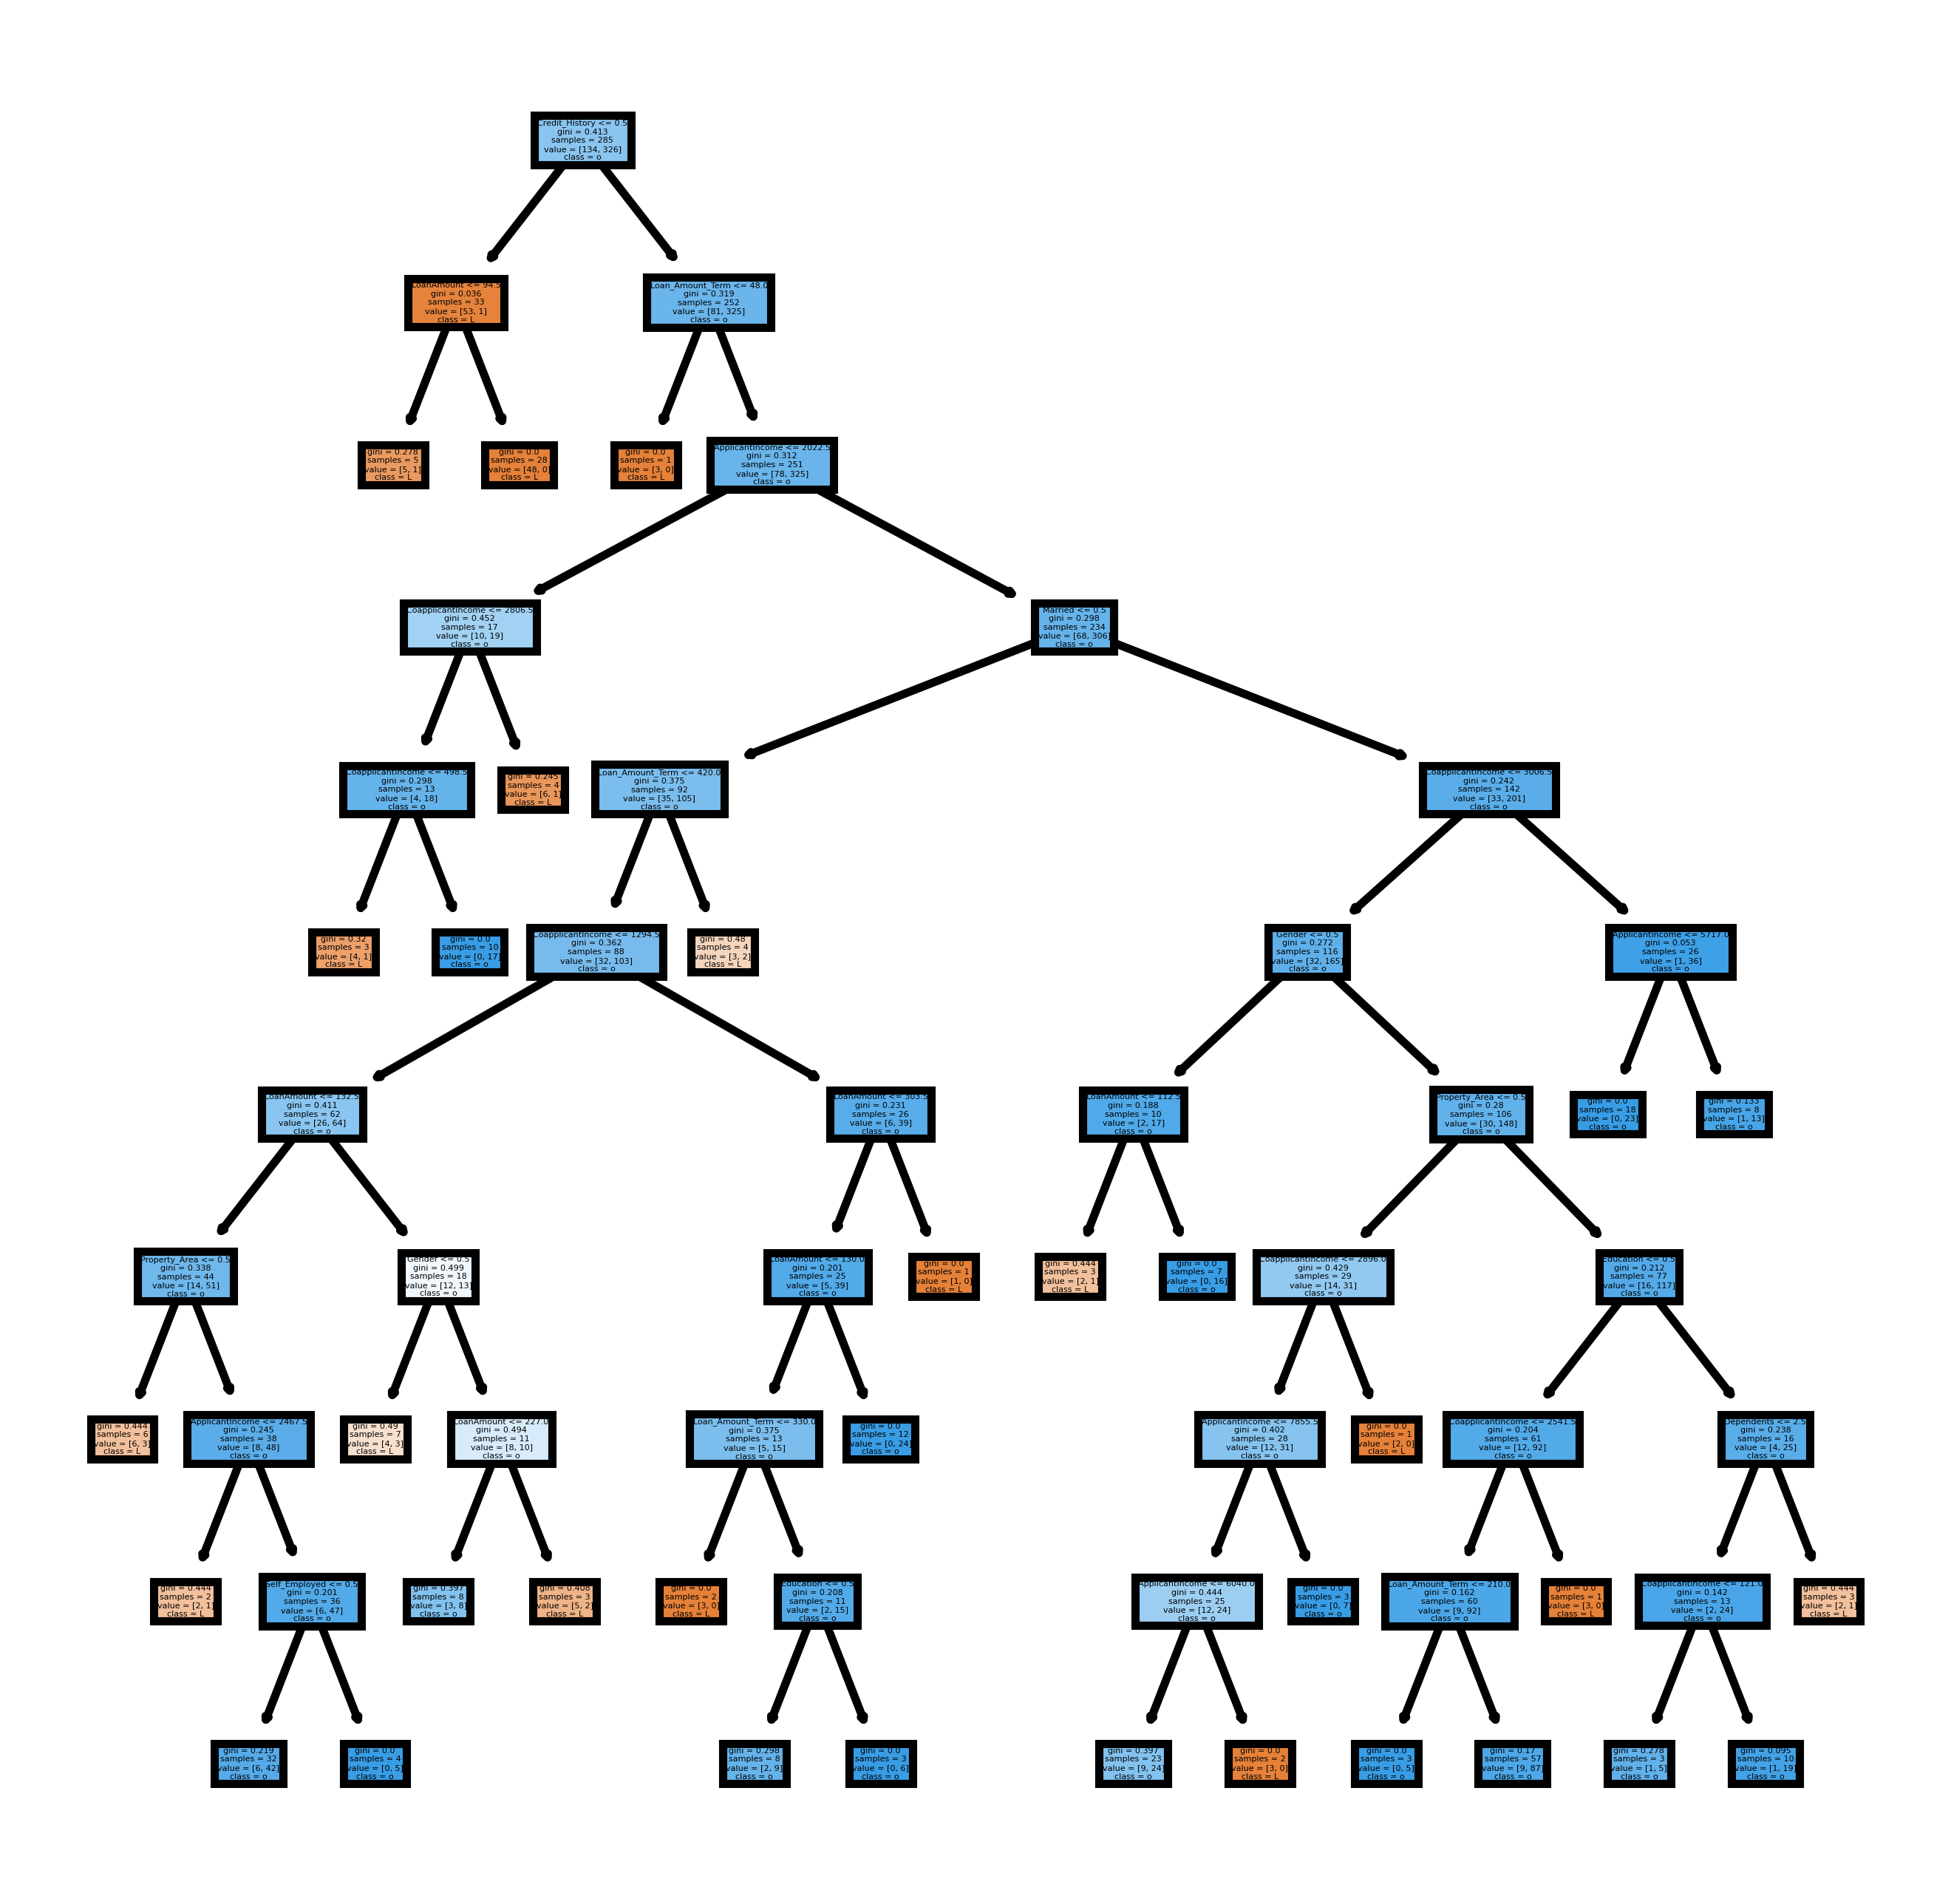

In [28]:
fn = X.columns
cn = y.name
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rfc_final.estimators_[0], feature_names = fn, 
               class_names = cn, filled = True);